# Machine Learning Final Project

## Step 0: Project Ideation & Dataset Inspection

### Instructions
1. **Dataset Loading**:

    - For each plan (e.g., Plan A, Plan B, etc.), read in the corresponding dataset.

2. **Inspect the Dataset**:

    - After loading the dataset, display the first few rows to understand its structure.

    - Identify and list the types of fields (e.g., numerical, categorical, text).

    - Attempt to identify the target variable if your project involves supervised learning.

### Plan A: Animal drug use adverse event

In [1]:
# Your code here
import pandas as pd
import re
import requests

# Define the base URL and initial query parameters
url = 'https://api.fda.gov/animalandveterinary/event.json?'
search = 'search=drug.active_ingredients.name:"Moxidectin"&limit=1000'
url = url + search

results = []

while True:
    # Make the request to the API
    a = requests.get(url)
    data = a.json()
    
    # Convert the JSON response to a DataFrame and select specific columns
    df = pd.DataFrame(data['results'])
    df = df[['treated_for_ae', 'reaction', 'time_between_exposure_and_onset', 'drug', 'health_assessment_prior_to_exposure', 'onset_date', 'animal', 'type_of_information', 'serious_ae', 'outcome']]
    results.append(df)
    
    # Try to get the next page URL from the 'Link' header
    try:
        link_header = a.headers.get('Link', '')
        b = re.search(r'<(https[^>]+)>', link_header)
        if b:
            next_url = b.group(1)
            url = next_url
        else:
            break
    except Exception as e:
        print(f"An error occurred: {e}")
        break

# Concatenate all DataFrames into one
df_combined = pd.concat(results, axis=0)

# Print information about the final DataFrame
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74845 entries, 0 to 844
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   treated_for_ae                       51922 non-null  object
 1   reaction                             74843 non-null  object
 2   time_between_exposure_and_onset      7237 non-null   object
 3   drug                                 74845 non-null  object
 4   health_assessment_prior_to_exposure  74845 non-null  object
 5   onset_date                           68531 non-null  object
 6   animal                               68776 non-null  object
 7   type_of_information                  74845 non-null  object
 8   serious_ae                           54204 non-null  object
 9   outcome                              56284 non-null  object
dtypes: object(10)
memory usage: 6.3+ MB


In [2]:
# Inspect the first five rows
df_combined.head()

,treated_for_ae,reaction,time_between_exposure_and_onset,drug,health_assessment_prior_to_exposure,onset_date,animal,type_of_information,serious_ae,outcome
0,false,"[{'veddra_version': '11', 'veddra_term_code': ...",NaN,"[{'first_exposure_date': '20170915', 'last_exp...","{'condition': 'Unknown', 'assessed_by': 'Veter...",20170922,"{'species': 'Cattle', 'gender': 'Mixed', 'repr...",Safety Issue,false,"[{'medical_status': 'Outcome Unknown', 'number..."
1,NaN,"[{'veddra_version': '11', 'veddra_term_code': ...",NaN,"[{'route': 'Oral', 'used_according_to_label': ...",{'assessed_by': 'Veterinarian'},20010717,"{'species': 'Horse', 'gender': 'Female', 'age'...",Safety Issue,NaN,"[{'medical_status': 'Died', 'number_of_animals..."
2,NaN,"[{'veddra_version': '11', 'veddra_term_code': ...",NaN,"[{'route': 'Unknown', 'lot_number': 'NOT RECOR...",{'assessed_by': 'Veterinarian'},20040529,"{'species': 'Dog', 'gender': 'Female', 'reprod...",Safety Issue,NaN,NaN
3,NaN,"[{'veddra_version': '11', 'veddra_term_code': ...",NaN,"[{'route': 'Oral', 'used_according_to_label': ...",{'assessed_by': 'Veterinarian'},19990724,"{'species': 'Horse', 'gender': 'Unknown', 'age...",Safety Issue,NaN,NaN
4,NaN,"[{'veddra_version': '6', 'veddra_term_code': '...",NaN,"[{'route': 'Topical', 'used_according_to_label...",{'assessed_by': 'Veterinarian'},20100118,"{'species': 'Dog', 'gender': 'Female', 'age': ...",Safety Issue,NaN,NaN


In [3]:
df_combined.shape

(74845, 10)

Because some of the fields are JSON objects, we want to further inspect them. 

We will want to parse these JSON objects in a way that is ingestible for our model. This will occur during EDA.

In [4]:
row_index = 0
column_label = 'outcome'
df_combined.iloc[row_index][column_label]

[{'medical_status': 'Outcome Unknown', 'number_of_animals_affected': '80'}]

### Plan B: Biomedical Image Analysis

In [1]:
!pip install medmnist pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 24.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 44.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.1 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 30.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 28.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 29.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... do

In [2]:
# Your code here
import medmnist
from medmnist import INFO
import numpy as np
from tqdm import tqdm
import pandas as pd

# Download the dataset
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Load training and testing datasets
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

# Inspect the dataset
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Example of loading the dataset into a DataLoader
train_loader = [(np.array(img), label) for img, label in tqdm(train_dataset)]
test_loader = [(np.array(img), label) for img, label in tqdm(test_dataset)]

100%|██████████| 205615438/205615438 [00:07<00:00, 27921735.75it/s]


Using downloaded and verified file: /home/vscode/.medmnist/pathmnist.npz
Train dataset size: 89996
Test dataset size: 7180


100%|██████████| 7180/7180 [00:00<00:00, 31914.54it/s]


Convert `train_loader` and `test_loader` into Dataframes, `train_df` and `test_df`. We can store these dataframes in a SQL databases for safekeeping (Step 3).

In [3]:
# Convert train_loader to DataFrame
train_df = pd.DataFrame(train_loader, columns=['img', 'label'])

# Convert test_loader to DataFrame
test_df = pd.DataFrame(test_loader, columns=['img', 'label'])

# Inspect train_df
train_df.head()

,img,label
0,"[[[220, 208, 227], [219, 207, 227], [220, 207,...",[0]
1,"[[[126, 59, 119], [142, 84, 139], [174, 127, 1...",[4]
2,"[[[223, 168, 204], [223, 166, 203], [218, 170,...",[7]
3,"[[[216, 135, 183], [216, 127, 178], [213, 125,...",[5]
4,"[[[204, 124, 177], [204, 116, 170], [211, 149,...",[5]


Each row represents an image and its corresponding label. The values you see under `img` are the pixel values of the images. These arrays are typically multi-dimensional, with each dimension corresponding to different properties of the image. Let's inspect a single image,

In [3]:
# Select an index to view
index = 4  # Change this to view a different image

# From the train_dataset
# image, label = train_dataset[index]

# Or from the train_loader
image, label = train_loader[index]

# Convert image to numpy array if needed
image = np.array(image)
image

array([[[204, 124, 177],
        [204, 116, 170],
        [211, 149, 190],
        ...,
        [216, 153, 194],
        [224, 185, 214],
        [233, 211, 228]],

       [[207, 132, 182],
        [209, 141, 188],
        [205, 127, 176],
        ...,
        [216, 153, 194],
        [227, 190, 217],
        [235, 217, 232]],

       [[226, 179, 211],
        [215, 156, 197],
        [212, 150, 193],
        ...,
        [207, 141, 185],
        [211, 154, 193],
        [229, 196, 219]],

       ...,

       [[216, 171, 205],
        [206, 151, 191],
        [214, 162, 200],
        ...,
        [217, 173, 207],
        [219, 176, 207],
        [225, 197, 220]],

       [[210, 164, 200],
        [218, 168, 203],
        [228, 199, 221],
        ...,
        [215, 164, 202],
        [219, 181, 210],
        [227, 209, 227]],

       [[231, 214, 229],
        [228, 202, 223],
        [231, 204, 224],
        ...,
        [194, 124, 176],
        [217, 170, 205],
        [229, 206, 225]]

The images are in color because the array is 3D with dimensions `(height, width, channels)`, where `channels` is usually 3 (representing the Red, Green, and Blue color channels). Each element in the array represents the intensity of the corresponding color channel for a pixel.

Below we can see that the images are 28x28 pixels and RGB (in color),

In [4]:
np.shape(image)

(28, 28, 3)

These arrays are used as input for machine learning models, where the model processes these pixel values to learn patterns and make predictions based on the images.

Lets use `matplotlib` to render the image from the pixel data,

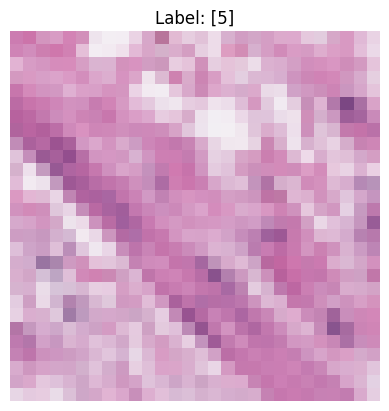

In [5]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image, cmap='gray')  # Use 'gray' for grayscale images
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

Inspect 9 random images with their associated label,

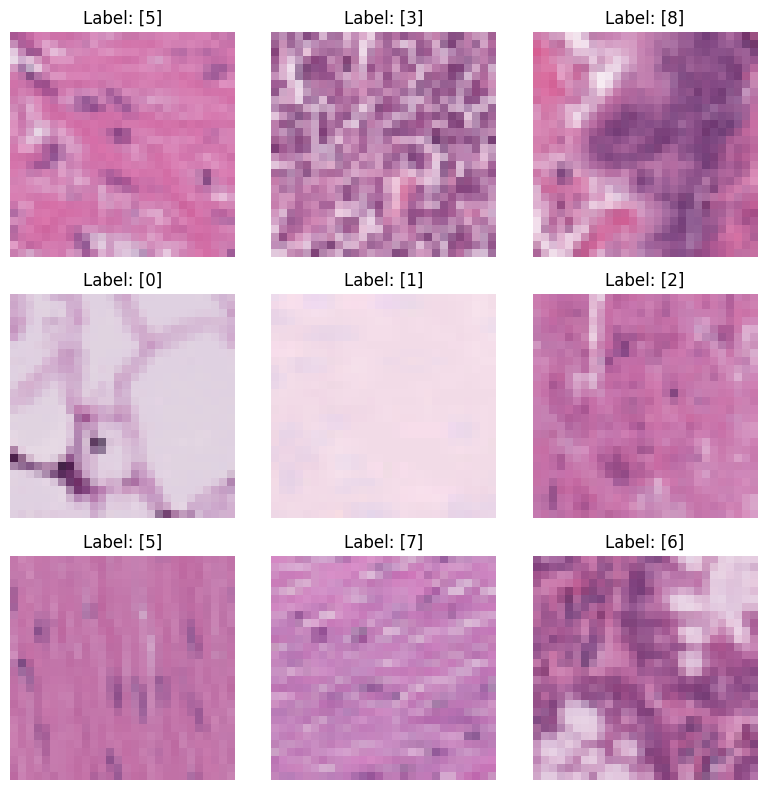

In [6]:
import random

# Select 9 random indices
random_indices = random.sample(range(len(train_dataset)), 9)

# Create a 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop over the 9 random indices and display each image
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[random_indices[i]]
    
    # Convert image to numpy array if needed
    image = np.array(image)
    
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [7]:
# Extract all labels from the train_dataset
labels = [label.item() for _, label in train_dataset]

# Get unique labels
unique_labels = list(set(labels))

# Print unique labels
print("Unique labels:", unique_labels)

Unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8]


<span style="color: red;">**TODO: Write code to obtain the mapping of the labels. Example:** `{0: 'dog', 1: 'cat', 2: 'mouse', ...}`</span>

In [ ]:
# Your code here

### Plan C: Website Fact Checker

In [10]:
# Your code here

## Step 1: Problem definition

### Instructions

1. **Select a Project Plan:**

    - Review the dataset options from Plan A, Plan B, and Plan C.

    - Choose one of the plans to move forward with based on your dataset inspection and interest.

2. **Write a Project Description:**

    - Clearly define the problem or question you intend to address with your selected dataset.

    - Consider how your chosen dataset can help solve this problem or answer the question.

    - Write a one-sentence description that clearly states the objective of your project. This should include what you aim to achieve or understand with the dataset.

3. **Name the Project:**

    - Create a name for your project that reflects the focus of your work.

### 1. Select a Project Plan

Plan B: Predicting Colon Cancer Histology Slide Content Using Deep Learning

### 2. Write a Project Description

Problem Definition:
The project aims to develop a machine learning model capable of accurately predicting the content of histology slides related to colon cancer. This involves analyzing images of colon cancer tissue to identify specific features and patterns that can indicate the presence and type of cancerous cells. The dataset comprises 100,000 non-overlapping image patches, each representing one of nine classes: adipose tissue (ADI), background (BACK), debris (DEB), lymphocyte (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), and CRC Epithelium (TUM). Accurately classifying these image patches is crucial for aiding in the diagnosis and treatment planning of colon cancer.

Dataset Utilization:
The chosen dataset from MedMNIST.com provides a collection of labeled histology images specific to colon cancer. By training the model on this dataset, we aim to create a tool that can assist pathologists in diagnosing colon cancer more effectively.

Objective:
The objective of this project is to use deep learning techniques to classify and predict the contents of colon cancer histology slides, ultimately aiding in the early and accurate detection of colon cancer.

### 3. Name the Project

Project Title: Predicting Colon Cancer Histology Slide Content Using Deep Learning

## Step 2: Acquiring and loading the data set

### Instructions

1. **Acquiring the Dataset:** Describe how you have acquired the dataset for your project. Depending on the method you used:

    1. **Web Scraping:**

        - If you used web scraping, provide details about the website or web page from which you extracted data.

        - Include information on the tools or libraries you used for scraping (e.g., BeautifulSoup, Scrapy).

        - Mention any challenges faced during the scraping process and how you addressed them.

    2. **SQL Database:**

        - If you obtained data from a public database using SQL, specify the database you accessed.

        - Describe the SQL queries you used to extract the data.

        - Include any relevant details about the database schema and how you navigated it.

    3. **Public API:**

        - If you accessed data through a public API, provide details about the API.

        - Describe the API endpoints you used and any parameters or filters applied to your requests.

        - Mention the format of the data returned by the API and how you processed it.

2. **Loading the Dataset:**

    - Detail the steps you followed to load the dataset into your working environment.

    - Describe the tools or libraries used for loading the data (e.g., `Pandas` for CSV files, `SQLAlchemy` for SQL databases, `requests` or an API client library for APIs).

    - Include any data cleaning or preprocessing steps you performed to prepare the data for analysis.

3. **Document Your Process:**

    - Provide a brief summary of your data acquisition and loading process, highlighting any key steps or decisions.

    - Include any challenges or issues encountered and how you resolved them.

There is a premade package that we have downloaded and used the documentation to dowload all of the images and set them up

in an SQL database.  Though, honestly, using the prebuilt custom DataLoader class based in pytorch will likely be much more sensible

for our purposes, as it will automatically batch the images and take care of much of the headache.

## Step 3: Store the information

### Instructions

1. **Choose a Database:**

    - Select a database that is most compatible with your dataset. Consider factors such as the size of the data, the complexity of the queries you plan to perform, and the features offered by the database.

    - The databases we have studied include SQLite, PostgreSQL, MySQL, etc.

2. **Store the Data:**

    - Import the dataset into the chosen database. This may involve creating tables and defining schemas that match the structure of your data.

    - Ensure that the database is properly set up to handle the data efficiently. Consider indexing or other optimizations if necessary.

3. **Perform Queries:**

    - Write and execute SQL queries to interact with your stored data. Use the following types of queries:

        - `SELECT`: Retrieve specific data from your tables. For example, you can select columns or rows that meet certain criteria.

        - `JOIN`: Combine data from multiple tables based on related columns to perform more complex queries.

        - `INSERT`: Add new data to your tables if necessary.

        - Include any other relevant SQL operations that are useful for your analysis.
    
    - Alternatively, use Python wrappers for SQL (e.g., `SQLAlchemy`, `pandas`) if applicable. These wrappers can help you perform SQL operations more easily within a Python environment.

4. **Document Your Process:**

    - Provide a summary of how you stored your data in the database, including the database used and the structure of the tables.

    - Include examples of the SQL queries you wrote and explain how they help in starting the analysis.

    - Discuss any challenges faced during the data storage and querying process and how you addressed them.

<span style="color: red;">**TODO: Instead of writing and saving the images locally and then reading them again, save both** `train_df` **and** `test_df` **as separate tables in your SQL database. This will safeguard the pixel data and labels for both your train and test sets.**</span>

In [2]:

import medmnist
from medmnist import INFO

data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print(info['label'])


import pandas as pd
import sqlite3
from concurrent.futures import ThreadPoolExecutor

conn = sqlite3.connect('../Bump/DBIITheReckoning.db')
train_df.to_sql('Train_Data', conn)
test_df.to_sql('Test_Data', conn)

# csv = pd.read_csv('../Bump/pathmnist.csv')
# csv.head()
# conn = sqlite3.connect('../Bump/DBIITheReckoning.db')
# # csv.to_sql('CREATE TABLE "PATHMNIST"', conn)

# def binaryconvent(filename):
#     with open(filename, 'rb') as file:
#         bina = file.read()
#     return bina

# def badhabits(filename):
#     query = f"UPDATE PATHMNIST SET train0_0.png = (?) WHERE train0_0.png = {filename}"
#     habit = binaryconvent(filename)
#     conn = sqlite3.connect('../Bump/DBIITheReckoning.db')
#     conn.cursor().execute(query, habit)
#     conn.commit()

# nunya = ['../Bump/pathmnist/' + i for i in csv['train0_0.png'].to_list()]

# with ThreadPoolExecutor(max_workers=25) as executor:
#     executor.map(badhabits, nunya)

# # SQL Database


ModuleNotFoundError: No module named 'medmnist'

<span style="color: red;">**TODO: After saving** `train_df` **and** `test_df` **as separate tables in your SQL database, follow the steps below to retrieve the entire dataset for both the training set and test set.**</span>

1. Write a SQL `SELECT` statement to retrieve all the data from your training set table:

In [ ]:
cursor = conn.cursor()
query = 'SELECT * FROM '
for i in ['Train_Data', 'Test_Data']:
    que = query + i
    cursor.execute(que)
    print(cursor.fetchone())

2. Write a SQL `SELECT` statement to retrieve all the data from your test set table:

In [ ]:
# Your code here

## Step 4 & 5: Perform a descriptive analysis & full EDA

1. **Getting the Dimensions of the Dataframe**

    - Get the dimensions of the `train_df`. This will give you the number of rows (images) and columns in the dataframe.

In [ ]:
train_df.shape

$~~~~~~~~~~$- Get the dimensions of `test_df`.

In [ ]:
test_df.shape

2. **Checking for Missing Values**

    - Check and count how many rows have missing values in `train_df`. Drop/remove rows with missing values if any.

3. **Checking the Data Types of Columns**

    - Check the data type of of each column in the `train_df` DataFrame.

In [ ]:
train_df.info()

$~~~~~~~~~~$- Check and count how many rows have missing values in `test_df`. Drop/remove rows with missing values if any.

$~~~~~~~~~~$- Check the data type of of each column in the `test_df` DataFrame.

In [ ]:
test_df.info()

4. **Inspect the Data Type of `img`**

    - Inspect the data type of an individual `img` from `train_df`.

In [12]:
# This example has been done for you
first_train_img = train_df['img'].iloc[0]
type(first_train_img)

numpy.ndarray

$~~~~~~~~~~$- Inspect the data type of an individual `img` from `test_df`.

In [ ]:
blah = test_df['img'].iloc[0]
type(blah)

5. **Inspect the Data Type of `label`**

    - Inspect the data type of an individual `label` from `train_df`.

$~~~~~~~~~~$- Inspect the data type of an individual `label` from `test_df`.

In [ ]:
for i in [train_df, test_df]:
    type(i['label'].iloc[0])

6. **Casting the Label to an Integer**

    - Convert the `label` column from an array to an integer for `train_df`.

$~~~~~~~~~~$- Convert the `label` column from an array to an integer for `test_df`.

In [ ]:
for i in [train_df, test_df]:
    print(i['label'].iloc[0][0])

7. **Getting the Label Distribution**

    - Count the number of instances for each `label` in `train_df`.

In [ ]:
train_df['label'].value_counts()

$~~~~~~~~~~$- Count the number of instances for each `label` in `test_df`.

In [ ]:
test_df['label'].value_counts()

8. **Visualizing the Label Distribution**

    - Visualize the `label` distribution for `train_df` using a bar plot or histogram.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

bar = train_df['label'].value_counts().plot(kind='bar')
plt.show()

$~~~~~~~~~~$- Visualize the `label` distribution for `test_df` using a bar plot or histogram.

In [4]:
bar_nun = test_df['label'].value_counts().plot(kind='bar')
plt.show()

9. **Getting Image Dimensions**

    - Check the dimensions of the images to ensure consistency across the `train_df` dataset.

In [15]:
len([i for i in train_df['img'] if i.shape == (28,28,3)]) - len(train_df['img'])

$~~~~~~~~~~$- Check the dimensions of the images to ensure consistency across the `test_df` dataset.

In [16]:
len([i for i in test_df['img'] if i.shape == (28,28,3)]) - len(test_df['img'])

10. **Getting Pixel Intensity Statistics**

    - Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `train_df`.

In [8]:
import numpy as np
funcs = {'avg':np.mean, 'std':np.std, 'min':np.min, 'max':np.max}
for k, v in funcs.items():
    train_df[k] = train_df['img'].apply(v)


$~~~~~~~~~~$- Calculate basic statistics (mean, standard deviation, min, max) of pixel intensities across all images in `test_df`.

In [9]:
for k, v in funcs.items():
    test_df[k] = test_df['img'].apply(v)

11. **Analyzing a Correlation Between Image Intensity and Labels**

    - Analyze if there is any relationship between the average pixel intensity of an image and its label for `train_df`.

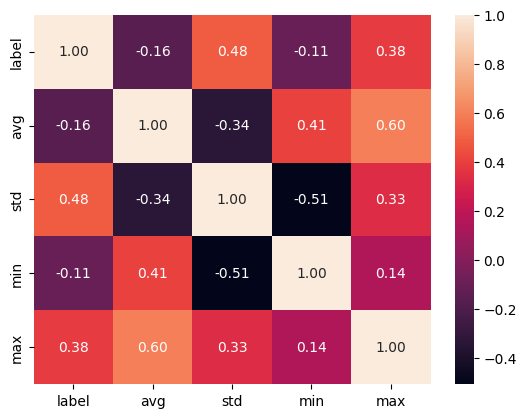

In [14]:
corr = train_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()

$~~~~~~~~~~$- Analyze if there is any relationship between the average pixel intensity of an image and its label for `test_df`.

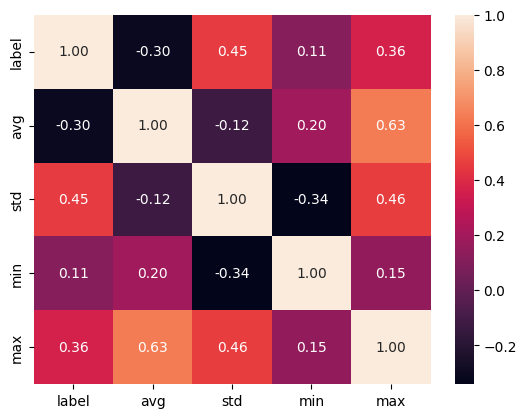

In [15]:
corr = test_df.drop(columns='img').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cbar=True)
plt.show()